# Syncing spike data with pycontrol

In [2]:
import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matplotlib.pylab as plt 
from tqdm.auto import tqdm
from trialexp.process.pyphotometry.utils import *
from trialexp.utils.ephys_utilities import create_sync_photo_ephys
import pandas as pd 
import xarray as xr

In [3]:
base = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin')
path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/ephys/sorting')

In [4]:
# Manualliy find the correct timestamp file for now
rec_properties = pd.read_csv(path.parent/'rec_properties.csv')
rec_properties.sync_path.iloc[2]

'/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/openephys/kms058_2023-03-23_18-48-08_bar_final/Record Node 104/experiment2/recording1/events/NI-DAQmx-103.PXIe-6341/TTL'

# Data sync

In [5]:
#load and create the sync object
# sync to photometry data for now, but later probably should sync everything back to pycontrol

photo_file = list((path.parents[1]/'pyphotometry').glob('*.ppd'))[0]
photo_data = import_ppd(photo_file)
photo_time = photo_data['pulse_times_2']
rsync = create_sync_photo_ephys(photo_time, path.parent/'correct')
assert rsync is not None

In [6]:
#load the spike extractor
probeA_sorting = si.load_extractor(path/'ProbeA')

In [7]:
# Sync and  all the sorting to ms
spike_times = []
Fs = 30000
max_time = 0
for id in tqdm(probeA_sorting.get_unit_ids()):
    spk_time = probeA_sorting.get_unit_spike_train(id)
    spk_time = spk_time/Fs*1000
    spk_time = rsync.A_to_B(spk_time)
    
    if len(spk_time)>0:
        max_time = max(max_time, spk_time[-1])
    spike_times.append(spk_time)

  0%|          | 0/962 [00:00<?, ?it/s]

In [8]:
# load xarray data and use that to bin the firing rate
xr_session = xr.load_dataset(path.parents[1]/'processed'/'xr_session.nc')

In [9]:
xr_session.time

<xarray.DataArray 'time' (time: 70629)>
array([  29621.5,   29671.5,   29721.5, ..., 3560921.5, 3560971.5, 3561021.5])
Coordinates:
  * time     (time) float64 2.962e+04 2.967e+04 ... 3.561e+06 3.561e+06

In [10]:
# convert spike timing to firing rate
# bin_size = 100
# bins = np.arange(0, np.ceil(max_time+bin_size), bin_size) #make sure we cover every bin

bins = xr_session.time.data
bin_size = 50

spike_rates = np.zeros((len(bins)-1, len(spike_times)))

for i in tqdm(range(len(spike_times))):
    count, _ = np.histogram(spike_times[i], bins) 
    spike_rates[:,i] = count * (1000/bin_size)

  0%|          | 0/962 [00:00<?, ?it/s]

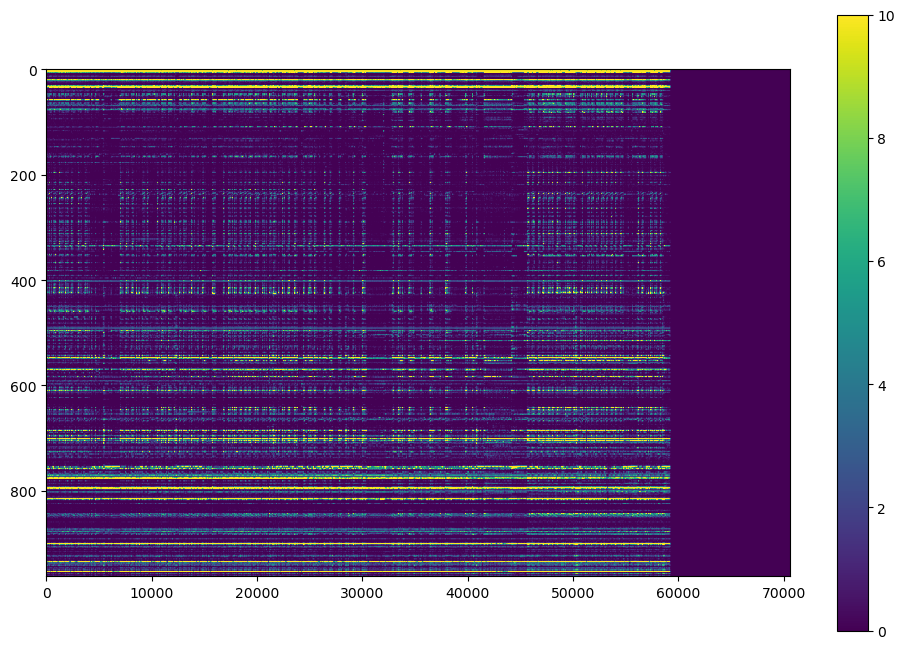

In [16]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.imshow(spike_rates.T, vmax=10)
plt.colorbar()
ax.set_aspect(50)
